# PyVista tutorial

This is a brief tutorial on how to use PyVista for data visualization. This is by no means a comprehensive tutorial on PyVista (and the VTK libraries), but it can offer some ideas on how to use PyVista to visualize data elaborated in Python

## Background
[PyVista](https://docs.pyvista.org/version/stable/) is basically a Python wrapper of [VTK](https://vtk.org/) (the Visualisation ToolKit), which is a very popular open-source software for manipulation and visualization of scientific data. Although VTK offers a Python wrapper, PyVista is generally much easier to use.

VTK is the basis upon which [Paraview](https://www.paraview.org/) is built. Paraview is probably the most famous tool used for post-processing CFD simulations. This means that we should be able to replicate in PyVista everything that we can do in Paraview directly in a Python script.

## Extract geometry from Paraview
Paraview is also important because it helps us extract the geometry file in a vtk format that can be read by PyVista. Once the simulation's data is loaded in Paraview, the geometry file can be saved by clicking `File > Save Data...`, select `VTK Multi Block Files(*.vtm)` as file type and choose the arrays to save with the geometry as well as the geometry blocks to include.

## Example dataset

The data and the geometry used in this tutorial are available on [Zenodo](https://www.zenodo.org/record/7786311), and can be downloaded by running the code in the next cell. The grid is already available in the `vtk` format.

The command `zenodo_get` can be installed via:
```console
pip install zenodo_get
```
Otherwise, the dataset can be downloaded directly from the website.

In [ ]:
import zenodo_get

! zenodo_get -d 10.5281/zenodo.7786311
! unzip DT_dataset.zip

## Load a geometry with PyVista

For CFD simulations, more often than not your mesh will be of the Unstructured type. This means that we need topological information for each cell to plot the data (which is the reason why PyVista is so helpful when dealing with CFD data).
The next cell shows how to load a mesh and print the relevant information.


In [29]:
import pyvista as pv

path = './DT_dataset'
# read the mesh using Pyvista
mesh = pv.read(f'{path}/grid.vtu')
print(mesh)



UnstructuredGrid (0x7fcbefa30460)
  N Cells:    191511
  N Points:   916290
  X Bounds:   -1.588e-07, 3.503e-01
  Y Bounds:   -6.344e-05, 3.500e-01
  Z Bounds:   -1.500e-01, 7.000e-01
  N Arrays:   1


The grid is of the `UnstructuredGrid` type, and it contains 191511 cells and 916290 points (it is a polyhedral grid). PyVista lets us convert a cell representation into a point representation very easily.

The number of arrays tells us how many arrays are stored together with the topological information of the grid. Before applying filters to the data (such as clipping, thresholding, slicing etc.) the data has to be stored into the grid. Then, the filtered information can be retrieved.

## Plot the mesh

Depending on the type of IDE you're using, PyVista lets you dynamically plot the mesh by creating an interactive window. VSCode works really well with PyVista, so I would recommend using it if you need this feature (you may need to install the `trame` python library).

In [ ]:
# plot the mesh in an interactive window
mesh.plot(cmap='inferno')

By default, PyVista will plot the active array (which is the last array loaded into the grid). In this case, there is only one array loaded, which is the temperature field.

## Save the plot

As in Paraview, you can save a screenshot of the 3D image of the plotted grid by using the `Plotter` class. Or, you can pass the screenshot to a `matplotlib` plot, and save it.

In [ ]:
import matplotlib.pyplot as plt

plotter = pv.Plotter()
plotter.add_mesh(mesh)
plotter.show(screenshot='screenshot_pv.png')

plt.imshow(plotter.image)
plt.savefig('screenshot_plt.png')
plt.show()

This method is very simple in itself, but it's very hard to produce high quality images (especially getting the camera in a good position is challenging). For this reason, I recommend extracting the information first with PyVista, and then use Matplotlib to plot the information.

## Plotting with Matplotlib

For example, if we want to plot a slice of a 3D grid, we can use the `slice` operation in PyVista, and then plot the data with the `tricontourf` command in Matplotlib.

In the next cell we plot a slice on the surface (x,z) of the furnace.

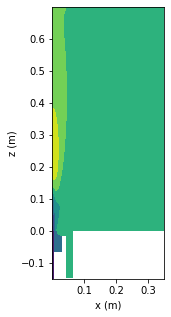

In [12]:
normal = (0, 1, 0) # the normal of the slicing plane is along y
origin = (0.0, 1.0e-3, 0) # the origin has to be inside the mesh

# the slicing operation can be done only to point data, so we need to convert the 
# cell data to point data with .ctp().
# We generate the triangles because we are going to use this info in the 
# tricontourf function.
plane = mesh.ctp().slice(normal=normal, origin=origin, generate_triangles=True)

x = plane.points # the coordinates of the points
tri = plane.faces.reshape((-1,4))[:, 1:] # the connectivity of the triangles

fig, ax = plt.subplots(figsize=(5,5))

# We pass to trincontourf the points, the triangles and the array to plot (temperature)
cs = ax.tricontourf(x[:,0], x[:,2], tri, plane.active_scalars, cmap='viridis')

ax.set_aspect('equal')
ax.set_xlabel(f'x (m)')
ax.set_ylabel(f'z (m)')

plt.show()

## Storing new data in the grid

If we need to plot new information on the same grid, we need first to store this information in the grid and then apply the filter. We can do that simply by assigning the new data as a numpy array to the mesh object. Based on the number of scalars in the numpy array, PyVista will automatically understand if the new array is a cell array or a point array.

First, we have to read the simulations.

In [16]:
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
import glob

# The simulations with different inlet diameter use different grids.
# We interpolate them on the coarsest grid, which is the one for D=25mm.
def read_simulation(filepath):
    sim = np.array(pd.read_csv(filepath))
    xyz = np.array(sim[:,1:4])

    column = np.empty((n, ))
    for i, f in enumerate(features):
        if xyz.shape[0] != n_cells:
            column[i*n_cells:(i+1)*n_cells] = griddata(xyz, sim[:,4+i], xyz_25, method='nearest')
        else:
            column[i*n_cells:(i+1)*n_cells] = sim[:,4+i]

    return column

# These are the parameters of the simulations
P_df = pd.read_csv(f'{path}/cases_parameters.csv')
P = np.array(P_df.iloc[:,2:]) 
m = P.shape[0]

# These are the features of the simulations
features = ['NOx', 'CO', 'OH', 'H2', 'H2O', 'CO2', 'O2', 'CH4', 'T']
n_features = len(features)

filepath = glob.glob(f'{path}/Numerical_data/Case6_*')
xyz_25 = np.array(pd.read_csv(filepath[0]).iloc[:,1:4])
n_cells = xyz_25.shape[0]

n = n_features*n_cells
X = np.empty((n,m))
for i in range(P_df.shape[0]):
    filepath =  glob.glob(f'{path}/Numerical_data/Case{P_df.iloc[i,1]}_*')
    X[:,i] = read_simulation(filepath[0])
    print(f'Simulation {i+1}/{m}', end='\r', flush=True)

Then we store the OH field of one of the simulation in the mesh object and we plot it as before.

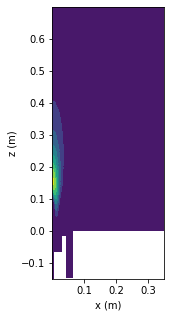

In [30]:
feature = 'OH' # the feature to plot
i_feature = features.index(feature)

# We store the field as 'z'
z = X[i_feature*n_cells:(i_feature+1)*n_cells, 0]
mesh['z'] = z

normal = (0, 1, 0)
origin = (0.0, 1.0e-3, 0) 
plane = mesh.ctp().slice(normal=normal, origin=origin, generate_triangles=True)
x = plane.points 
tri = plane.faces.reshape((-1,4))[:, 1:]

fig, ax = plt.subplots(figsize=(5,5))

# We retrieve the information as plane['z]
cs = ax.tricontourf(x[:,0], x[:,2], tri, plane['z'], cmap='viridis')

ax.set_aspect('equal')
ax.set_xlabel(f'x (m)')
ax.set_ylabel(f'z (m)')

plt.show()

## 3D contours

Sometimes (especially for presentations) is useful to compute 3-dimensional contours of the data. We can do that using the `contour` function.

In [65]:
feature = 'T' # the feature to plot
i_feature = features.index(feature)

# We store the field as 'z'
z = X[i_feature*n_cells:(i_feature+1)*n_cells, 0]
mesh['z'] = z
mesh_rot = mesh.rotate_z(150).rotate_y(-10)
contour = mesh_rot.ctp().contour(np.linspace(1400, mesh['z'].max(), 10), scalars='z')

pl = pv.Plotter(off_screen=True)
pl.add_mesh(contour, opacity=0.7, lighting=False, show_scalar_bar=False, cmap='plasma')
pl.add_mesh(mesh_rot, color='w', opacity=0.2)  
pl.set_background('w')
pl.show(screenshot='countours_pv.png')

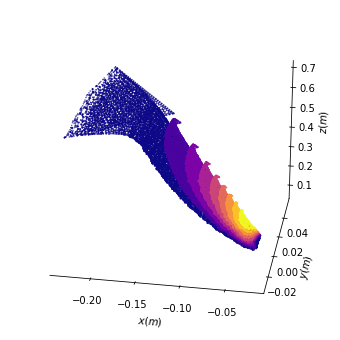

In [72]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')


ax.scatter(contour.points[:,0], contour.points[:,1], 
           contour.points[:,2], c=contour['z'], cmap='plasma', s=1, marker='.', alpha=0.7)

ax.set_xlabel('$x (m)$')
ax.set_ylabel('$y (m)$')
ax.set_zlabel('$z (m)$')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)

ax.view_init(elev=25, azim=-80)
plt.show()